# Mammography images classification using Deep Learning(CNN)

* Convolutional neural networks (CNN) is used to convert digital image content into a single vector of numbers(numeric vector) representing the unique characteristics of the image. 
* The column of numbers is inputted to a Dense fully connected Neural network layer against the labels
* The classification model learns these numeric vector inputs against the labels

In [ ]:
# !pip install keras
# !pip install tensorflow

In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import random

# Importing Library for Data Visualization
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import seaborn as sns 
import cv2

# Importing Tensorflow for model creation and its dependencies
import tensorflow

# Generate batches of tensor image data with real-time data augmentation.
from keras.preprocessing.image import ImageDataGenerator

# for enabling inline plotting
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

TrainingImagePath=R'/content/drive/MyDrive/ML/data/train'
TestingImagePath=R'/content/drive/MyDrive/ML/data/test'
ValidationImagePath=R'/content/drive/MyDrive/ML/data/validation'

import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(TrainingImagePath).rglob("*.*")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)
            os.remove(img_p)

**Create directory variables. Count, and show images**


In [ ]:
'''########################## IMAGE PRE-PROCESSING for TRAINING and TESTING data ##############################'''

# Defining pre-processing transformations on raw images of training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

# Defining pre-processing transformations on raw images of testing data
test_datagen = ImageDataGenerator(rescale=1./255)

# Generating the Training Data
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')


# Generating the Testing Data
test_set = test_datagen.flow_from_directory(
        TestingImagePath,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

# Generating the Tested Data
valid_set = test_datagen.flow_from_directory(
        ValidationImagePath,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

Found 7970 images belonging to 3 classes.
Found 2319 images belonging to 3 classes.
Found 1231 images belonging to 3 classes.


In [ ]:
# Function to plot any random image from dataset
def showImages(class_name):
    
    folder_path=os.path.join(TrainingImagePath, class_name)
    flist=os.listdir(folder_path)
    test_img=random.choice(flist)
    test_img=os.path.join(folder_path, test_img)
    try:
        plt.imshow(mpimg.imread(test_img),cmap='Greys_r')
    except:
        plt.imshow(mpimg.imread(test_img),cmap='Greys_r')
    plt.title(class_name)
    plt.axis(False)

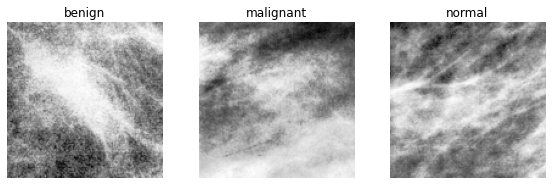

In [ ]:
plt.figure(figsize = (20,20))
for labels,number in training_set.class_indices.items():
    plt.subplot(6,6,number+1)
    showImages(labels)


In [ ]:
# Printing class labels for each face
test_set.class_indices

{'benign': 0, 'malignant': 1, 'normal': 2}

# Creating a list of **classes**

In [ ]:
'''#################### Creating lookup table for all cells ##############################'''
# class_indices have the numeric tag for each cell
TrainClasses=training_set.class_indices

# Storing the cell and the numeric tag for future reference
ResultMap={}
for cellValue,cellName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[cellValue]=cellName

print("Mapping of cell and its ID",ResultMap)

# The number of neurons for the output layer is equal to the number of classes
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of cell and its ID {0: 'benign', 1: 'malignant', 2: 'normal'}

 The Number of output neurons:  3


### Creating the CNN model

In [ ]:
'''######################## Create CNN deep learning model ####################################'''
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

'''Initializing the Convolutional Neural Network'''
classifier= Sequential()

''' STEP--1 Convolution
# Adding the first layer of CNN
# we are using the format (64,64,3) because we are using TensorFlow backend
# It means 3 matrix of size (64X64) pixels representing Red, Green and Blue components of pixels
'''
classifier.add(Convolution2D(32, kernel_size=(3, 3), strides=(1, 1), input_shape=(128,128,3), activation='relu'))
'''# STEP--2 MAX Pooling'''
classifier.add(MaxPool2D(pool_size=(2,2)))

'''############## ADDITIONAL LAYER of CONVOLUTION for better accuracy #################'''
classifier.add(Convolution2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))

'''# STEP--3 FLattening'''
classifier.add(Flatten())

'''# STEP--4 Fully Connected Neural Network'''
classifier.add(Dense(256, activation='relu'))
classifier.add(Dense(OutputNeurons, activation='softmax'))

'''# Compiling the CNN'''
#model.compile(loss='categorical_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['acc'], run_eagerly=True)
classifier.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=["accuracy"])

In [ ]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 57600)             0         
                                                                 
 dense_4 (Dense)             (None, 256)              

### Fitting the model

In [ ]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Starting the model training
model_history=classifier.fit_generator(
                                        training_set,
                                        steps_per_epoch=len(training_set),
                                        epochs=10,
                                        validation_data=valid_set,
                                        validation_steps=len(valid_set),
                                        verbose=1)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

<ipython-input-46-5bab2da064be>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history=classifier.fit_generator(


Epoch 1/10
250/250 [==============================] - 118s 472ms/step - loss: 0.6915 - accuracy: 0.8136 - val_loss: 0.6059 - val_accuracy: 0.8034
Epoch 2/10
250/250 [==============================] - 53s 211ms/step - loss: 0.5708 - accuracy: 0.8233 - val_loss: 0.5236 - val_accuracy: 0.8091
Epoch 3/10
250/250 [==============================] - 49s 198ms/step - loss: 0.5204 - accuracy: 0.8319 - val_loss: 0.5498 - val_accuracy: 0.8034
Epoch 4/10
250/250 [==============================] - 52s 208ms/step - loss: 0.5036 - accuracy: 0.8335 - val_loss: 0.6101 - val_accuracy: 0.8099
Epoch 5/10
250/250 [==============================] - 50s 198ms/step - loss: 0.5375 - accuracy: 0.8365 - val_loss: 0.4961 - val_accuracy: 0.8197
Epoch 6/10
250/250 [==============================] - 49s 197ms/step - loss: 0.4838 - accuracy: 0.8409 - val_loss: 0.5126 - val_accuracy: 0.8213
Epoch 7/10
250/250 [==============================] - 52s 209ms/step - loss: 0.4643 - accuracy: 0.8445 - val_loss: 0.5967 - val_a

In [ ]:
accuracy = model_history.history['accuracy']
val_accuracy  = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

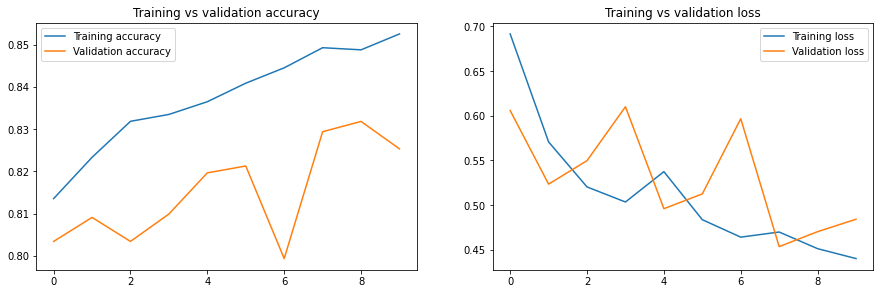

In [ ]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

### Confusion Matrix

In [ ]:
!pip install  scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import seaborn as sns
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)
predictions = classifier.predict(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)   


73/73 [==============================] - 740s 10s/step
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       160
   malignant       0.11      0.03      0.05       267
      normal       0.82      0.97      0.89      1892

    accuracy                           0.79      2319
   macro avg       0.31      0.33      0.31      2319
weighted avg       0.68      0.79      0.73      2319



In [ ]:
y_pred = np.argmax(predictions, axis=1)  
confusion_matrix = confusion_matrix(true_classes, y_pred)  

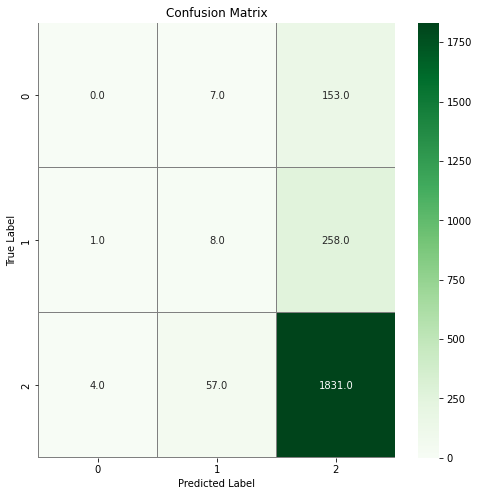

In [ ]:
import seaborn as sns

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Saving the model

In [ ]:
## Saving the model
classifier.save(R"/content/drive/MyDrive/ML/classifier.pkl")

### Testing the model 

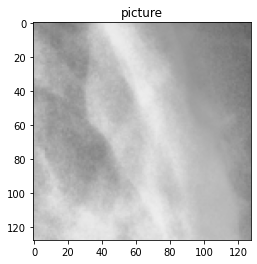

########################################
Prediction is:  normal


In [ ]:
'''########################## Making single predictions ############################'''
from tensorflow.keras.utils import load_img, img_to_array

testImage=R"/content/drive/MyDrive/ML/data/test/normal/1.png"
test_image=load_img(testImage,target_size=(128, 128))
test_image=img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
result=classifier.predict(test_image,verbose=0)

img = cv2.imread(testImage)

plt.imshow(img)
plt.title('picture')
plt.show()

print('####'*10)
print('Prediction is: ',ResultMap[np.argmax(result)])

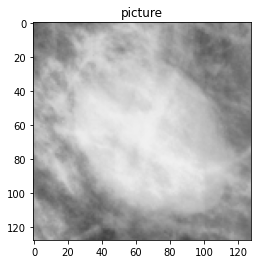

########################################
Prediction is:  malignant


In [ ]:
'''########################## Making single predictions ############################'''
testImage=R"/content/drive/MyDrive/ML/data/test/benign/9217.png"
test_image=load_img(testImage,target_size=(128, 128))
test_image=img_to_array(test_image)

test_image=np.expand_dims(test_image,axis=0)
result=classifier.predict(test_image,verbose=0)

img = cv2.imread(testImage)
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

plt.imshow(img)
plt.title('picture')
plt.show()

print('####'*10)
print('Prediction is: ',ResultMap[np.argmax(result)])

# Graphic interface 

In [ ]:
!pip install anvil-uplink

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 7.5 MB/s 
     |████████████████████████████████| 51 kB 228 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=0156f8c4e94c8c26949ee7f30580691b0dc25ada406e44c5e9b48229f782435f
  Stored in directory: /root/.cache/pip/wheels/ea/f9/a1/34e2943cce3cf7daca304bfc35e91280694ced9194a487ce2f
Successfully built ws4py


In [ ]:

import anvil.server
import anvil.media 
from PIL import Image
import io
anvil.server.connect("4ZZKEBP5S3IJBXUXNQGFWBCQ-2IOOYRWX7JMD27XV")

In [ ]:
@anvil.server.callable
def predict_mammography(file):
  with anvil.media.TempFile(file) as filename:
    img = load_img(filename)
    img = img.resize((128,128) ,resample=PIL.Image.BICUBIC) 
    arr= img_to_array(img)
    test_image=np.expand_dims(arr,axis=0)
    result=classifier.predict(test_image,verbose=0)


    return (ResultMap[np.argmax(result)])

[web app](https://2iooyrwx7jmd27xv.anvil.app/BSNACMBQNPLJTYTFMTP4VYS4)

In [ ]:
anvil.server.wait_forever()